# Supernova spectrum matching and classification notebook

### Import packages needed and define a stats function

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from functions import ProcessSpectra, BinSpec, split, get_classification, dered, get_spec_matches, target_wavelength_range
from glob import glob
from joblib import dump, load
import os

In [2]:
# def pad(spectrum, target_wavelength_range = target_wavelength_range, deredden = False):
    
#     x, y = np.loadtxt(spectrum, unpack = True)
    
#     if deredden:
#         y = dered(x, y, 3.1, deredden)
    
#     if min(x) > min(target_wavelength_range):
        
#         dx = x[1] - x[0]
#         pad_x = np.arange(min(target_wavelength_range) - dx*5, min(x), dx  )
#         pad_y = [y[0] for n in range(len(pad_x))]
        
#         x = np.concatenate((pad_x, x))
#         y = np.concatenate((pad_y, y))
#         np.savetxt(spectrum + '.padded.txt', list(zip(x,y)), fmt="%s")   
    
#         return spectrum + '.padded.txt'
    
#     else:
        
#         if deredden:
#             np.savetxt(spectrum + '.dered.txt', list(zip(x,y)), fmt="%s") 
#             return spectrum + '.dered.txt'
        
#         else:
#             return spectrum


def get_z_stats(get_sn = False, get_type = False, plot = True ):
    '''
    Returns the stats for either a particular supernova as defined by get_sn,
    or a particular type as defined by get_type.
    Output is one tuple and two arrays; 
    
    [0] = (median, mean, std)
    [1] = redshift array
    [2] = weights array for plt.hist weights argument
    '''
    
    
    # set the empty lists
    stats = []
    w = []
    
    # set parameters for a supernova or a type
    if get_sn:
        sn_matches = [get_sn]
        list_to_use = sne
        
    if get_type:
        sn_matches = set(sne)
        list_to_use = types
     
    # iterate through the lists to get the redshifts that match the conditions
    for this_sn in sn_matches:        
        for idx ,obj in enumerate(list_to_use):
            
            if (obj == this_sn) or (obj == get_type):
                stats.append(zs[idx])
                w. append(sorted_scores[idx])
                
    # normalise the scores to the score in the list. This is for 'weights' in plt.hist            
    w =  ( w / max(sorted_scores) ) ** 4 
    
    # cast as numpy array
    stats = np.array(stats)
    w = np.array(w)
    
    if plot:
        plt.hist(stats, weights = w, color = 'k', facecolor = 'tab:green', zorder = 0, rwidth= 0.9, density = True)
        plt.axvline(x = np.average(stats, weights = w), linestyle = 'dashed' , color = 'k')
        plt.axvline(x = np.average(stats, weights = w) + np.std(stats), linestyle = 'dotted', color = 'k' )
        plt.axvline(x = np.average(stats, weights = w) - np.std(stats), linestyle = 'dotted', color = 'k' )
        plt.xlabel('Redshift')
        plt.ylabel('weighted counts')
    
    return (np.median(stats), np.average(stats, weights = w), np.std(stats) ), stats, w


Load the model and the list of classifications for the spectra in the model

In [3]:
# Load the model
model_location = './models/Gr13_KNNClassification_model.k=1000.joblib'
clf = load(model_location) 

# load the class list for this model
classlist = np.loadtxt('./PCA_ready/classlist.Gr13.txt',dtype='str')
classlist.sort()

# set the list of the spectra for the templates
ref_sne = glob('./spectra/*')
ref_location = './spectra/'

## User defined
### Set the input spectrum

In [4]:
specname = 'tATLAS21cbe_20210201_Gr13_Free_slit1.0_1_f.asci'

spectrum = f'./for_classification/{specname}'


In [29]:
folder = '/Users/sprentice/Documents/Pessto_run_feb21/2Feb/classifications/'

# print the file names in order
spectra = glob(folder +'*.asci')
for idx, i in enumerate(spectra):
    print(idx, os.path.basename(i ) )

# choose the object and set extinction
index = 3
E = 1.6/3.1
# Set if redshift is known
redshift = False

# set spectum name ad if necessary pad and deredden
spectrum = spectra[index]
#spectrum = pad(specname, deredden = E)

# print the chose spectrum for classification
print(f'\nclassifying {os.path.basename(spectrum) }')

0 tATLAS21dha_20210201_Gr13_Free_slit1.0_1_f.asci
1 tAT2021ayi_20210201_Gr13_Free_slit1.0_1_f.asci
2 tAT2021bjm_20210201_Gr13_Free_slit1.0_1_f.asci
3 tATLAS21dhb_20210201_Gr13_Free_slit1.0_1_f.asci
4 tAT2021bjk_20210201_Gr13_Free_slit1.0_1_f.asci
5 tATLAS21cbe_20210201_Gr13_Free_slit1.0_1_f.asci
6 tATLAS21brt_20210201_Gr13_Free_slit1.0_1_f.asci
7 tAT2021avj_20210201_Gr13_Free_slit1.0_1_f.asci
8 tAT2021bkw_20210201_Gr13_Free_slit1.0_1_f.asci

classifying tATLAS21dhb_20210201_Gr13_Free_slit1.0_1_f.asci


# Get the best match and the scores for all the matches

In [30]:
best_match, indices, scores = get_classification(spectrum, clf, E = E)
best_match_properties = split(best_match)[0]
best_match_properties
print(f'The best match is {best_match_properties[0]} {best_match_properties[1]} (t = {best_match_properties[3]} d) at z = {best_match_properties[2]}')

The best match is Ia SN2012fr (t = 7.74 d) at z = 0.034


### Sort all the matches by score then return them in a list

In [31]:
sorted_scores, sorted_idxs = zip(*list(sorted(zip(scores,indices), reverse=True)))



a  = get_spec_matches(idxs = sorted_idxs, z = redshift, classlist = classlist )
types, sne, zs, epochs, all_specs = zip(*a)

# list the top 15 matches
a[:15]

[('Ia', 'SN2012fr', 0.034, 7.74, 'Ia_SN2012fr_7.74_.txt'),
 ('Ia', 'SN2012fr', 0.036, 7.74, 'Ia_SN2012fr_7.74_.txt'),
 ('Ia', 'SN2012fr', 0.032, 7.74, 'Ia_SN2012fr_7.74_.txt'),
 ('Ia', 'SN2012fr', 0.032, 8.76, 'Ia_SN2012fr_8.76_.txt'),
 ('Ia', 'SN2012fr', 0.034, 8.76, 'Ia_SN2012fr_8.76_.txt'),
 ('Ia', 'SN2012fr', 0.034, 8.74, 'Ia_SN2012fr_8.74_.txt'),
 ('Ia', 'SN2012fr', 0.032, 8.74, 'Ia_SN2012fr_8.74_.txt'),
 ('Ib', 'SN2009jf', 0.03, -12.71, 'Ib_SN2009jf_-12.71_.txt'),
 ('Ia', 'SN2012fr', 0.03, 8.76, 'Ia_SN2012fr_8.76_.txt'),
 ('Ia', 'SN2012fr', 0.038, 7.74, 'Ia_SN2012fr_7.74_.txt'),
 ('Ia', 'SN2012fr', 0.036, 8.76, 'Ia_SN2012fr_8.76_.txt'),
 ('Ib', 'SN2009jf', 0.028, -12.71, 'Ib_SN2009jf_-12.71_.txt'),
 ('Ia', 'SN2012fr', 0.036, 8.74, 'Ia_SN2012fr_8.74_.txt'),
 ('Ia', 'SN2012fr', 0.032, 8.03, 'Ia_SN2012fr_8.03_.txt'),
 ('Ia', 'SN2012fr', 0.03, 8.74, 'Ia_SN2012fr_8.74_.txt')]

In [32]:
print(set(types), set(sne))

{'Ic-BL', 'Ia', 'Ia-91T', 'II', 'Ic-7', 'Ib', 'IIb', 'Ia-91bg'} {'SN2007gr', 'SN2005ke', 'SN1999aa', 'SN2005cf', 'SN2008ax', 'SN2009jf', 'SN2013dy', 'SN2011fe', 'SN2003du', 'SN2006aj', 'SN2012fr', 'SN2013ej', 'iPTF13bvn'}


### Plot all the redshifts and phases

Text(0.5, 0, 'Redshift')

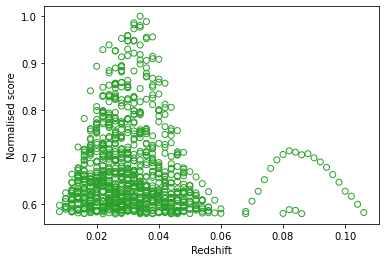

In [33]:
plt.scatter( zs, sorted_scores / max(sorted_scores), facecolor = 'none', color = 'tab:green')
plt.ylabel('Normalised score')
plt.xlabel('Redshift')

Text(0.5, 0, 'Epoch [days]')

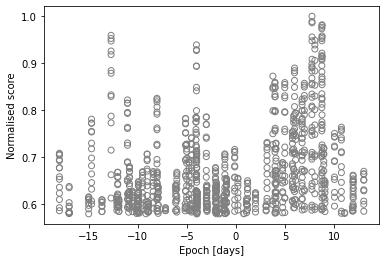

In [34]:
plt.scatter(epochs, sorted_scores / max(sorted_scores), facecolor = 'none', color = 'grey')
plt.ylabel('Normalised score')
plt.xlabel('Epoch [days]')

## Plot the best 15 matches

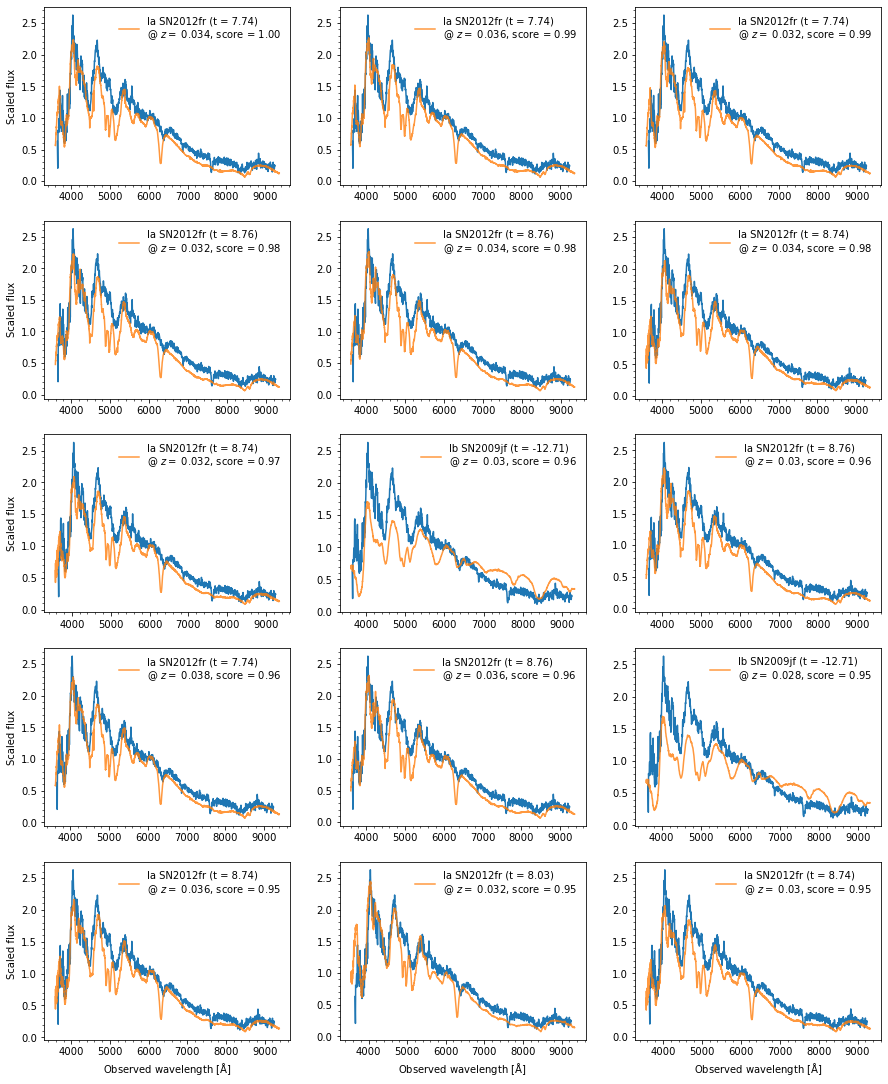

In [37]:
x , y = np.loadtxt(spectrum, usecols = (0,1) ,unpack= True )

if E:
    y = dered(x, y, 3.1, E)

ref_lam = 6000

scale = y[np.argmin(abs(x - ref_lam))]
y = y / scale

plt.figure(figsize = (15,19))
for i, spec in enumerate(all_specs):
    if i <15: 
        
        plt.subplot(5,3, i + 1)
        plt.plot(x, y)
    
        x_, y_ = np.loadtxt(ref_location + spec, unpack = True)
    
        x_ = x_ * (1 + zs[i])
    
        scale = y_[np.argmin(abs(x_ - ref_lam))]
        y_ = y_ / scale
        
        fit_score = sorted_scores[i] / max(sorted_scores)
        plt.plot(x_, y_, label = f'{types[i]} {sne[i]} (t = {epochs[i]})\n@ $z=$ {zs[i]}, score = {fit_score:.2f}', alpha = 0.8)

        plt.legend(frameon = False)
        plt.minorticks_on()
        # this messes up if i changes
        if i in  [0, 3, 6, 9, 12]:
            plt.ylabel('Scaled flux')
        if i in [14, 13 ,12]:
            plt.xlabel('Observed wavelength [$\mathrm{\AA}$]')
        
        
    else:
        break



## Plot the redshift distributions
The first selects on SN type, be careful with this as although the bins components are weighted according to score
having a lot in one bin with a marginally lower score than the best fit gives a shifted average e.g., the sampling is not uniform!

z = 0.040 +-0.009


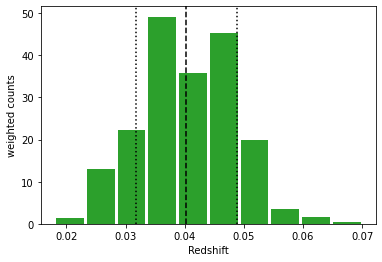

In [121]:
z_stats = get_z_stats(get_type = 'Ia')
print(f'z = {z_stats[0][1]:.3f} +-{z_stats[0][2]:.3f}'  )

The same again but for an individual SN. Again the bin components are weighted according to score. This should be a little better than filtering on SN types

z = 0.039 +-0.008


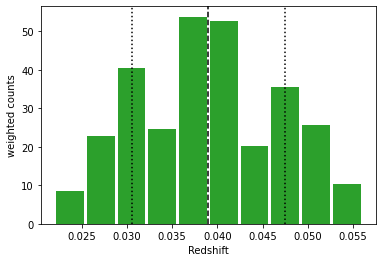

In [122]:
z_stats = get_z_stats(get_sn = 'SN2011fe')
print(f'z = {z_stats[0][1]:.3f} +-{z_stats[0][2]:.3f}'  )

### Plot individual SN matches.
Simply define a part of the SN name to include in the search

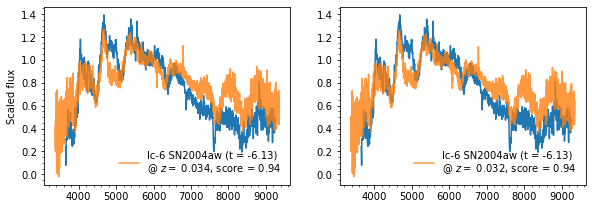

In [158]:
x , y = np.loadtxt(spectrum, usecols = (0,1) ,unpack= True )

scale = y[np.argmin(abs(x-6000))]
y = y / scale

# need a rising index
n= 0

plt.figure(figsize = (15,19))
for i, spec in enumerate(all_specs):
    if '04aw' in spec and n < 15: 
        
        plt.subplot(5,3, n + 1)
        plt.plot(x, y)
    
        x_, y_ = np.loadtxt(ref_location + spec, unpack = True)
    
        x_ = x_ * (1 + zs[i])
    
        scale = y_[np.argmin(abs(x_ - 6000))]
        y_ = y_ / scale
    
        plt.plot(x_, y_, label = f'{types[i]} {sne[i]} (t = {epochs[i]})\n@ $z=$ {zs[i]}, score = {fit_score:.2f}', alpha = 0.8)

        plt.legend(frameon = False)
        plt.minorticks_on()
        
        # this messes up if the limit of n changes
        if n in  [0, 3, 6, 9, 12]:
            plt.ylabel('Scaled flux')
        if n in [14, 13 ,12]:
            plt.xlabel('Observed wavelength [$\mathrm{\AA}$]')
        #plt.show()
        n+=1
